In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer

# 데이터 불러오기
df = pd.read_csv('/kaggle/input/emotion/Emotion_classification.csv')

# 사용할 감정 필터링 (행복, 불안, 분노, 중립)
selected_emotions = ['행복', '불안', '분노', '중립']
df = df[df['감정'].isin(selected_emotions)]

# 감정 라벨 인코딩
label_encoder = LabelEncoder()
df['감정'] = label_encoder.fit_transform(df['감정'])

# 텍스트와 라벨 분리
texts = df['발화'].values
labels = np.array(df['감정'].values, dtype=np.int32)  # 정수형으로 변환

# 학습/검증 데이터셋 분리
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# BERT 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# 토큰화 및 패딩 적용
max_len = 100
X_train_tok = tokenizer(list(X_train), max_length=max_len, padding=True, truncation=True, return_tensors='tf')
X_test_tok = tokenizer(list(X_test), max_length=max_len, padding=True, truncation=True, return_tensors='tf')


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [9]:
from transformers import TFBertForSequenceClassification, create_optimizer
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# BERT 모델 로드 (다중 클래스 분류용)
model = TFBertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=len(selected_emotions))

# 클래스 가중치 계산
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))




All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# 옵티마이저 및 학습률 스케줄러 설정
num_train_steps = len(X_train) // 16 * 3  # 에포크 수를 고려한 총 스텝 수 계산
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=num_train_steps)

# 모델 컴파일 (명시적으로 from_logits=True 설정)
model.compile(optimizer=optimizer, loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# 학습
history = model.fit(
    {'input_ids': X_train_tok['input_ids'], 
     'attention_mask': X_train_tok['attention_mask'], 
     'token_type_ids': X_train_tok['token_type_ids']}, 
    y_train,
    validation_data=({'input_ids': X_test_tok['input_ids'], 
                      'attention_mask': X_test_tok['attention_mask'], 
                      'token_type_ids': X_test_tok['token_type_ids']}, y_test),
    epochs=5,  # BERT는 일반적으로 적은 에포크로도 높은 성능을 발휘
    batch_size=16,
    class_weight=class_weights_dict
)

Epoch 1/5
4937/4937 [==============================] - 1880s 368ms/step - loss: 0.6184 - accuracy: 0.7630 - val_loss: 0.5033 - val_accuracy: 0.8136
Epoch 2/5
4937/4937 [==============================] - 1806s 366ms/step - loss: 0.4518 - accuracy: 0.8331 - val_loss: 0.4614 - val_accuracy: 0.8293
Epoch 3/5
4937/4937 [==============================] - 1806s 366ms/step - loss: 0.3618 - accuracy: 0.8676 - val_loss: 0.4637 - val_accuracy: 0.8348
Epoch 4/5
4937/4937 [==============================] - 1807s 366ms/step - loss: 0.3173 - accuracy: 0.8865 - val_loss: 0.4637 - val_accuracy: 0.8348
Epoch 5/5
4937/4937 [==============================] - 1808s 366ms/step - loss: 0.3171 - accuracy: 0.8872 - val_loss: 0.4637 - val_accuracy: 0.8348


In [11]:
# 모델 평가
loss, accuracy = model.evaluate(
    {'input_ids': X_test_tok['input_ids'], 
     'attention_mask': X_test_tok['attention_mask'], 
     'token_type_ids': X_test_tok['token_type_ids']}, 
    y_test
)
print(f'Accuracy: {accuracy*100:.2f}%')

618/618 [==============================] - 129s 208ms/step - loss: 0.4637 - accuracy: 0.8348
Accuracy: 83.48%


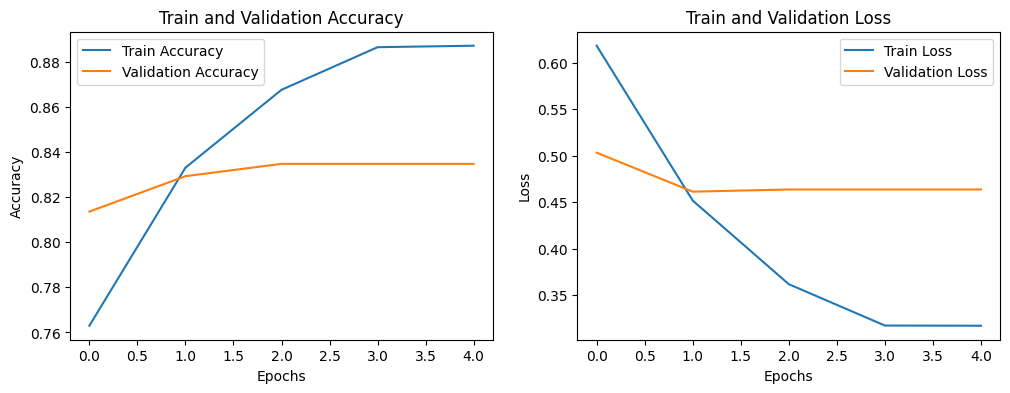

In [108]:
import matplotlib.pyplot as plt

# 학습 및 검증 정확도 시각화
plt.figure(figsize=(12, 4))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [67]:
# 모델 저장
model.save_pretrained('C:/saved_model/bert_emotion_classification')

# 토크나이저 저장
tokenizer.save_pretrained('C:/saved_model/bert_emotion_classification')


('C:/saved_model/bert_emotion_classification/tokenizer_config.json',
 'C:/saved_model/bert_emotion_classification/special_tokens_map.json',
 'C:/saved_model/bert_emotion_classification/vocab.txt',
 'C:/saved_model/bert_emotion_classification/added_tokens.json')

In [71]:
from transformers import TFBertForSequenceClassification, BertTokenizer

# 저장된 모델 로드
loaded_model = TFBertForSequenceClassification.from_pretrained('C:/saved_model/bert_emotion_classification')

# 저장된 토크나이저 로드
loaded_tokenizer = BertTokenizer.from_pretrained('C:/saved_model/bert_emotion_classification')


Some layers from the model checkpoint at C:/saved_model/bert_emotion_classification were not used when initializing TFBertForSequenceClassification: ['dropout_151']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at C:/saved_model/bert_emotion_classification.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [87]:
import pandas as pd

# 데이터 파일 불러오기
df = pd.read_csv('/kaggle/input/emotion/Emotion_classification.csv')

# 감정 레이블과 매핑 확인
print(df['감정'].value_counts())
print(df['감정'].unique())


감정
중립    48616
슬픔    27517
분노    19710
불안    15999
당황    14670
행복    14406
혐오     5649
Name: count, dtype: int64
['분노' '행복' '불안' '당황' '슬픔' '혐오' '중립']


In [94]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# 데이터 불러오기
df = pd.read_csv('/kaggle/input/emotion/Emotion_classification.csv')

# 사용할 감정 필터링 (행복, 불안, 분노, 중립)
selected_emotions = ['행복', '불안', '분노', '중립']
df = df[df['감정'].isin(selected_emotions)]

# 감정 라벨 인코딩
label_encoder = LabelEncoder()
df['감정_encoded'] = label_encoder.fit_transform(df['감정'])

# 레이블 매핑 확인
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label mapping:", label_mapping)


Label mapping: {'분노': 0, '불안': 1, '중립': 2, '행복': 3}


In [106]:
# 감정 레이블 매핑 (실제 인코딩된 값에 따라 설정)
emotion_labels = {0: '분노', 1: '불안', 2: '중립', 3: '행복'}

# 예시 텍스트
texts = ["기숙사 신청 날짜를 착각해서 신청을 못했는데 어쩌지?"]

# 텍스트 토큰화
inputs = tokenizer(texts, max_length=100, padding=True, truncation=True, return_tensors='tf')

# 예측 수행
predictions = model(inputs['input_ids'], attention_mask=inputs['attention_mask'], token_type_ids=inputs['token_type_ids'])

# 예측 결과 해석
predicted_class = tf.argmax(predictions.logits, axis=1).numpy()[0]

# 예측된 감정을 텍스트로 변환
predicted_emotion = emotion_labels.get(predicted_class, "Unknown")

# 결과 출력
print(f"이 문장은 '{predicted_emotion}'에 대한 문장입니다.")


이 문장은 '불안'에 대한 문장입니다.


618/618 [==============================] - 138s 206ms/step


/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 45432 (\N{HANGUL SYLLABLE NO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48520 (\N{HANGUL SYLLABLE BUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50504 (\N{HANGUL SYLLABLE AN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/I

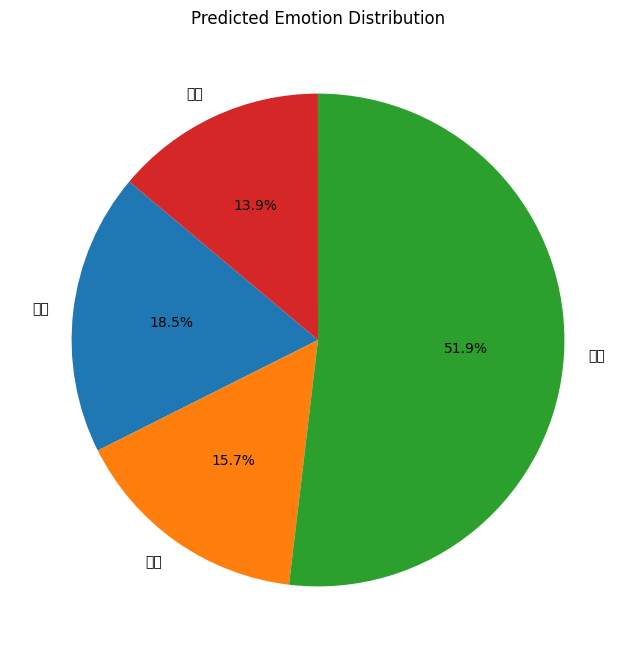

In [109]:
import matplotlib.pyplot as plt
import numpy as np

# 예측 수행 (여기서는 이미 학습된 모델을 사용하여 테스트 데이터에 대해 예측을 수행한다고 가정)
predictions = model.predict({'input_ids': X_test_tok['input_ids'], 
                              'attention_mask': X_test_tok['attention_mask'], 
                              'token_type_ids': X_test_tok['token_type_ids']})

# 각 예측된 클래스의 레이블을 가져오기
predicted_classes = np.argmax(predictions.logits, axis=1)

# 감정 레이블 매핑 (이전에 설정한 것)
emotion_labels = {0: '분노', 1: '불안', 2: '중립', 3: '행복'}

# 각 감정별 예측 개수 계산
unique, counts = np.unique(predicted_classes, return_counts=True)
predicted_distribution = dict(zip([emotion_labels[cls] for cls in unique], counts))

# 파이 차트 그리기
plt.figure(figsize=(8, 8))
plt.pie(predicted_distribution.values(), labels=predicted_distribution.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Predicted Emotion Distribution')
plt.show()
